<a href="https://colab.research.google.com/github/YasmineJiang/codespace/blob/main/British_Airline_Review_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [36]:
#Libraries for web scrapping
import requests
from bs4 import BeautifulSoup
#Libraries for data manipulation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#Libraries for sentiment analysis
import gensim
from gensim import corpora
from textblob import TextBlob
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

# **Web Scrapping**

In [37]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 373

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 373 total reviews
Scraping page 2
   ---> 746 total reviews
Scraping page 3
   ---> 1119 total reviews
Scraping page 4
   ---> 1492 total reviews
Scraping page 5
   ---> 1865 total reviews
Scraping page 6
   ---> 2238 total reviews
Scraping page 7
   ---> 2611 total reviews
Scraping page 8
   ---> 2984 total reviews
Scraping page 9
   ---> 3357 total reviews
Scraping page 10
   ---> 3729 total reviews


In [43]:
!mkdir Data

In [44]:
df = pd.DataFrame()
df["reviews"] = reviews
df.to_csv("Data/BA_reviews.csv", index=False)

# **Exploratory Data Analysis**

In [ ]:
#Load Data
data = pd.read_csv("BA_reviews.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3729 entries, 0 to 3728
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3729 non-null   int64 
 1   reviews     3729 non-null   object
dtypes: int64(1), object(1)
memory usage: 58.4+ KB


In [ ]:
#Data Cleaning
data['reviews'] = data['reviews'].str.split("|").apply(lambda x: x[1] if len(x) > 1 else x[0])

#Data Preparation for Sentiment Analysis
sentiment_list = []
for i in data['reviews']:
    blob = TextBlob(i)
    sentiment = blob.sentiment.polarity
    sentiment_list.append(sentiment)

data['Score'] = sentiment_list

conditions = [
    (data['Score'] >= 0.7) &(data['Score'] <= 1),
    (data['Score'] >= 0.3) & (data['Score'] < 0.7),
    (data['Score'] >= 0.1) & (data['Score'] < 0.3),
    (data['Score'] >= -0.1) & (data['Score'] < 0.1),
    (data['Score'] >= -0.3) & (data['Score'] < -0.1),
    (data['Score'] >= -0.7) & (data['Score'] < -0.3),
    (data['Score'] >= -1) & (data['Score'] < -0.7)
]

choices = ['Strongly positive', 'Moderately positive', 'Slightly positive', 'Neutral','Strongly negative', 'Moderately negative', 'Slightly negative']
data['Result'] = np.select(conditions, choices, default='Not Specified')
data = data.drop('Unnamed: 0', axis=1)

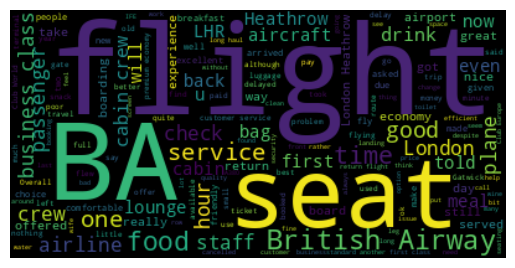

In [ ]:
#Word Cloud Analysis
text = ' '.join(data['reviews'].dropna().values)
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Text(0, 0.5, 'Frequency')

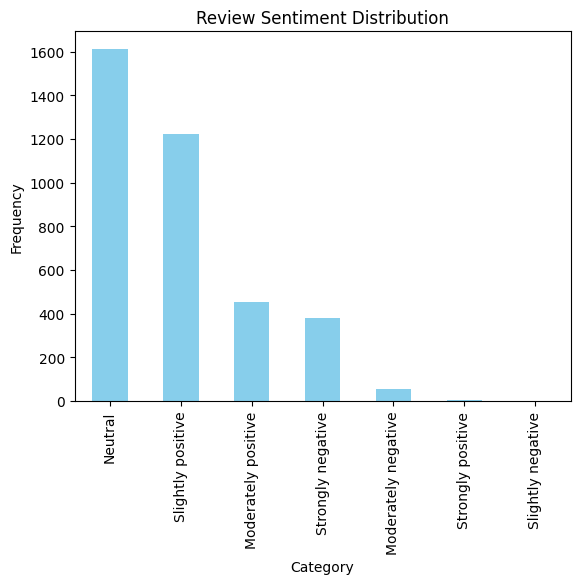

In [ ]:
#Data Visualization
category_counts = data['Result'].value_counts()
ax = category_counts.plot(kind='bar', color='skyblue')
plt.title('Review Sentiment Distribution')
plt.xlabel('Category')
plt.ylabel('Frequency')

#for p in ax.patches:
    #ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005), ha='left', va='top')

In [ ]:
# Analyzing the strongly negative sentiment
negative_data = data[data['Result'] == 'Strongly negative']

documents = negative_data['reviews']
stop_words = set(stopwords.words('english'))
texts = [[word for word in document.lower().split() if word not in stop_words]
         for document in documents]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


lda_model = gensim.models.ldamodel.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=15)
topics = lda_model.print_topics(num_words=4)
for topic in topics:
    print(topic)

(0, '0.011*"flight" + 0.010*"ba" + 0.009*"business" + 0.009*"class"')
(1, '0.017*"flight" + 0.010*"ba" + 0.007*"-" + 0.007*"british"')
(2, '0.010*"flight" + 0.009*"ba" + 0.005*"british" + 0.005*"airways"')
